# Overview
## Goals of this Study and Background Information

### The Bering Sea is an important region in the North Pacific, both oceanographically and economically. 

It borders the Arctic, allowing for exchange with hydrographically distinct Polar waters. Because of its position on a shallow continental shelf, the sea supports a diverse ecosystem, highlighted by one of the biggest commercial crab fisheries in the world. As atmospheric CO2 levels rise, the oceans acidity increases, threatening the stability of marine ecosystems. The Bering Sea is particularly vulnerable to acidification because of its already low pH. My study will use shipboard data from 2008-2010 to estimate trends in pH in the eastern Bering Sea and then relate pH and other hydrographic parameters to fluctuations in population across crab species in the Eastern Bering Sea, in an attempt to tease out broader impacts that acidification could have.

My driving questions are:
- How do acidity and related parameters vary with time and space in the Eastern Bering Sea? 
- Does acidity appear to have any impact on crab populations?

I expect a slight increase in acididty as atmospheric CO2 rises over the 5 year time span, and prior work has shown tanner crabs and red king crabs as more vulnerable at lower pH. I would expect to see more pronounced decreases in biomass for Tanner Crabs and Red King crabs. I expect temporal and spatial variance in acidity and other CO2 related parameters because of the high variability in environmental forcing in the Bering Sea (Sea Ice formation/removal, Solar Forcing, biological forcings).



# Setup
## Packages for analysis
I've imported the packages needed for my analysis, including PyCO2SYS, which I will use to calculate atmospheric CO2 from the Alkalinity and DIC data. Constraining two parameters(like Alkalinity and DIC) of the marine carbonate system allows for a modeled calculation of CO2. In additiion to this package, I've imported standard packages for analyzing large earth science datasets (pandas, xarray, numpy), in addition to tools that aid in visualization (cartopy, matplotlib).

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from cartopy import crs as ccrs, feature as cfeature
from matplotlib import pyplot as plt
import PyCO2SYS as pyco2

plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'

# DATA ASSEMBLAGE
## Compilation and Assimilation of Hydrographic Sections
The data is stored in CSV files by cruise, which I then downloaded and read into dataframes. Sometimes, I had to do a bit of cleaning; the July 2008 section had negative values recorded for Alkalinity, which defies the definition of Alkalinity as a concentration, so I filtered them out. I merged these dataframes into larger yearly dataframes, and then ultimately into one big dataframe with coverage for the entire dataset.


In [2]:
#Assembling my 2008 dataframe from the section csv files
jul2008csv = 'JUL_2008_bsC.exc.csv'
dfjul2008 = pd.read_csv(jul2008csv,parse_dates=['DATE'],
                 skiprows=[1])
dfjul2008 = dfjul2008[dfjul2008.ALKALI >= 0]
apr2008csv = 'APR_2008_bsC.exc.csv'
dfapr2008 = pd.read_csv(apr2008csv,parse_dates=['DATE'],
                 skiprows=[1])

df2008 = pd.concat([dfjul2008, dfapr2008])
df2008.LONGITUDE = df2008.LONGITUDE -360

In [3]:
#Assembling my 2009 dataframe from the section csv files
apr2009csv = 'apr2009BS.exc.csv'
dfapr2009 = pd.read_csv(apr2009csv, parse_dates=['DATE'], skiprows=[1])
JUL2009csv = 'jul2009BS.exc.csv'
dfjul2009 = pd.read_csv(JUL2009csv, skiprows=[1],parse_dates=['DATE'])
SEP2009csv = 'sep2009.exc.csv'
dfsep2009 = pd.read_csv(SEP2009csv, skiprows=[1],parse_dates=['DATE'])
dfsep2009
df2009 = pd.concat([dfapr2009, dfjul2009, dfsep2009])

In [4]:
#Assembling my 2010 dataframe from the section csv files
MAY2010csv = 'may2010BS.exc.csv'
dfmay2010 = pd.read_csv(MAY2010csv, skiprows=[1],parse_dates=['DATE'])


In [5]:
#Whole hydrographic section dataframe
dfbering = pd.concat([df2008, df2009, dfmay2010])
print(dfbering.head)

<bound method NDFrame.head of            EXPOCODE SECT_ID  STNNBR  CASTNO  SAMPNO  BTLNBR  BTLNBR_FLAG_W  \
84     33HQ20080703    BEST    11.0     1.0    85.0    85.0            2.0   
85     33HQ20080703    BEST    11.0     1.0    86.0    86.0            2.0   
86     33HQ20080703    BEST    11.0     1.0    87.0    87.0            2.0   
87     33HQ20080703    BEST    11.0     1.0    88.0    88.0            2.0   
88     33HQ20080703    BEST    11.0     1.0    89.0    89.0            2.0   
..              ...     ...     ...     ...     ...     ...            ...   
341      3.2502E+11    BEST  2017.0   220.0     NaN     NaN            2.0   
342      3.2502E+11    BEST  2015.0   222.0     NaN     NaN            2.0   
343      3.2502E+11    BEST  2015.0   222.0     NaN     NaN            2.0   
344      3.2502E+11    BEST  2015.0   222.0     NaN     NaN            2.0   
345        END_DATA     NaN     NaN     NaN     NaN     NaN            NaN   

          DATE    TIME  LATITUDE 

This dataset is from 6 distinct cruises over 3 years. The parameters that I use for my analysis in are: Alkalinity (ALKALI), Dissolve Inorganic Carbon (TCARBN), Temperature (CTDTMP), Salinity (CTDSAL), Pressure (CTDPRS), Total Silicate (SILCAT), Total Phosphate (PHSPHT), Date, Depth, Longitude, and Latitude.

In [6]:
from datetime import datetime
crabs = pd.read_csv('CRAB_CPUE_FOR_WEB.CSV')
crabs['DATE'] = pd.to_datetime(crabs['START_DATE'], format='%m/%d/%Y')
crabs = crabs.set_index('DATE')
print(crabs.head())
crabstudy = crabs.sort_index().loc['2008':'2011']

            HAULJOIN  LATITUDE  LONGITUDE STATION_ID  SURVEY_YEAR  START_DATE  \
DATE                                                                            
1976-06-10      2477  55.68333 -162.81667       C-09         1976  06/10/1976   
1976-06-21      2498  56.03333 -165.78333       D-04         1976  06/21/1976   
1976-06-14      2492  56.01667 -165.16667       D-05         1976  06/14/1976   
1976-06-14      2491  56.01667 -164.58333       D-06         1976  06/14/1976   
1976-06-14      2490  56.03333 -163.98333       D-07         1976  06/14/1976   

            START_HOUR    COMMON_NAME             SCIENTIFIC_NAME  \
DATE                                                                
1976-06-10        1700  red king crab  Paralithodes camtschaticus   
1976-06-21        1200  red king crab  Paralithodes camtschaticus   
1976-06-14        1300  red king crab  Paralithodes camtschaticus   
1976-06-14        1000  red king crab  Paralithodes camtschaticus   
1976-06-14        

This is a fisheries dataset on detailing crab CPUE for 6 different species with data on maturity included. The full data set extends from 1975-2024, but I have sliced it to the same time frame as the hydrographic data. The parameters I used from this dataset are CPUE, Start Date, and Common Name.

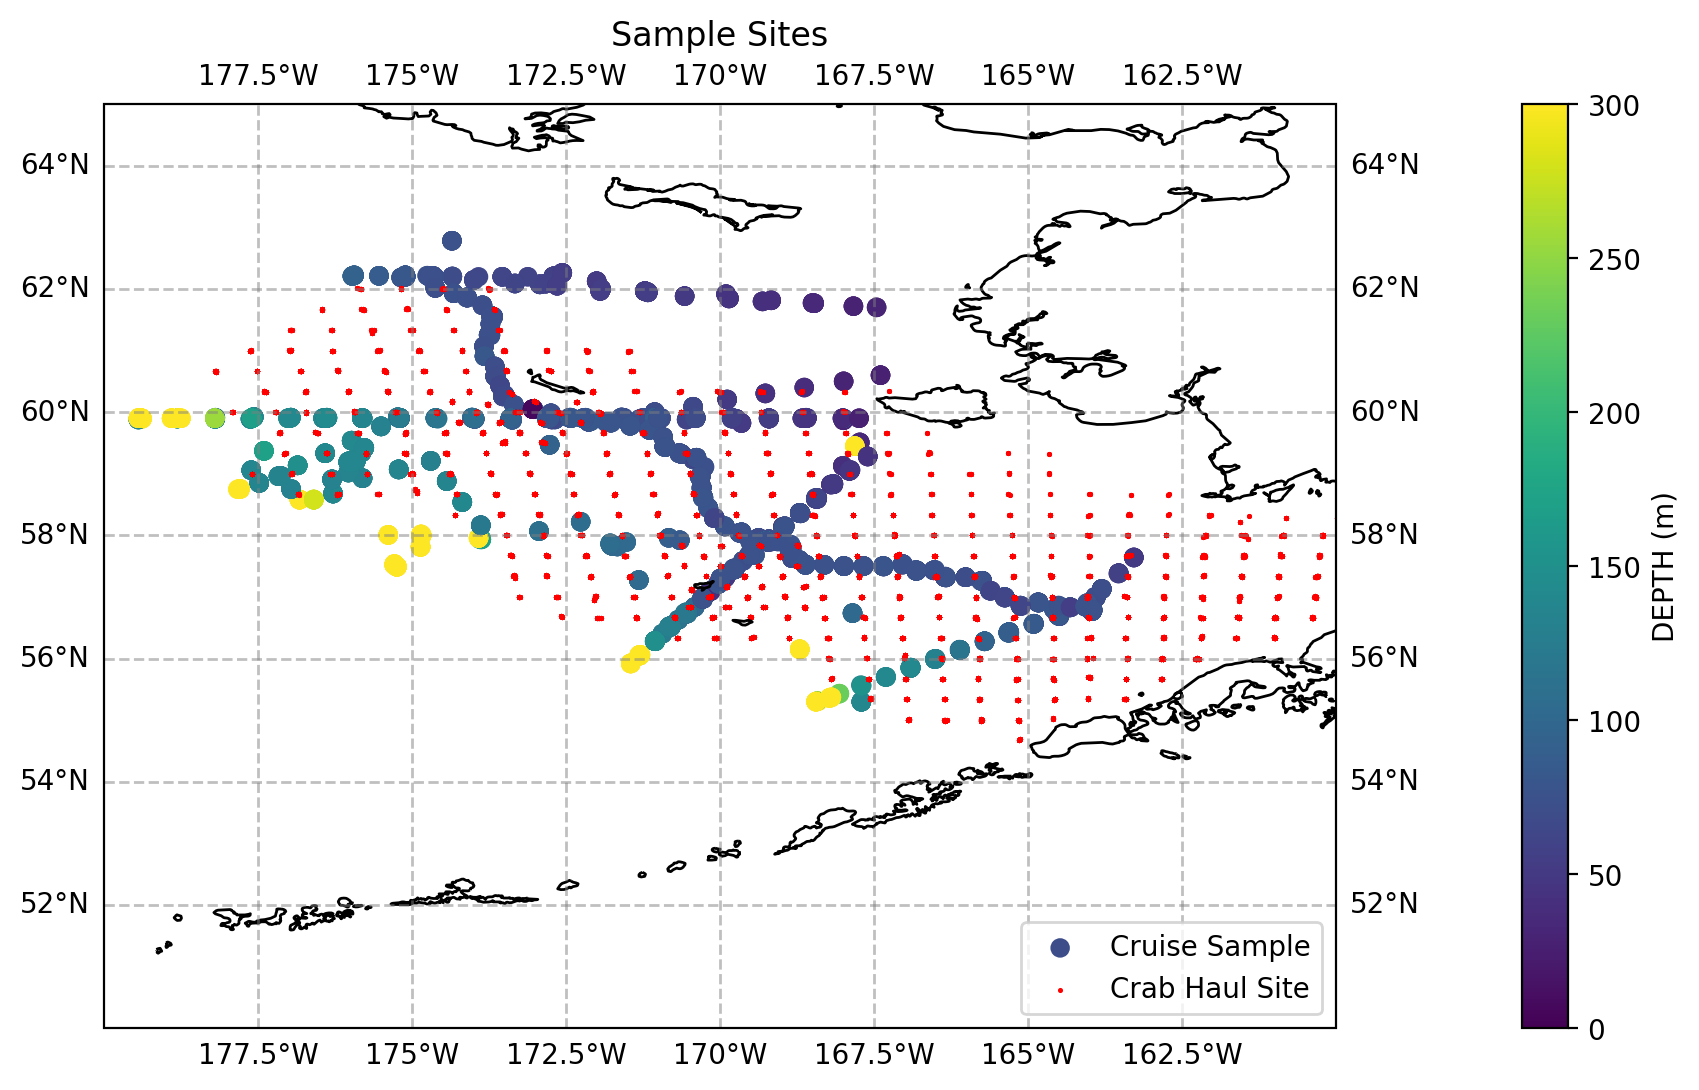

In [7]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-180, -160, 50, 65])
ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
)
ax.coastlines()
space_plot = ax.scatter(dfbering.LONGITUDE, dfbering.LATITUDE, c = dfbering.DEPTH, transform=ccrs.PlateCarree(), vmin = 0, vmax = 300 )
plt.colorbar(space_plot, label = 'DEPTH (m)', use_gridspec = True, pad =.1)
ax.scatter(x = crabstudy.LONGITUDE, y =crabstudy.LATITUDE, s = 0.7, color = 'red')
ax.set_title('Sample Sites')
ax.legend(['Cruise Sample', 'Crab Haul Site'], loc = "lower right")

The spatial distribution of the seawater chemistry dataset overlain with the haul location sites of crabs from 2008-2011. Note depth increasing with distance from coastline, and distance from the shallow bering shelf. Hydrographic section data is sparse and irregular.

# Calculation of CO2, pH


Variables defined from the sections were used calculate and model the marine carbonate system with the PyCO2SYS package. Alkalinity and DIC are the two parameters that are absolutely necessary for the calculation. The other parameters (temperature, salinity, pressure, silicate, and phosphate), provide constraints to the model output.

In [8]:
dfbering = dfbering[dfbering.TCARBN >= 0]
dfbering = dfbering[dfbering.ALKALI >= 0]
results = pyco2.sys(par1=dfbering['ALKALI'], par1_type=1, par2 = dfbering['TCARBN'], par2_type=2, temperature = dfbering['CTDTMP'],
                    salinity = dfbering['CTDSAL'], pressure = dfbering['CTDPRS'],
                    total_silicate = dfbering['SILCAT'],total_phosphate = dfbering['PHSPHT'])
dfbering['CO2'] = results['pCO2']
dfbering['pH'] = results['pH']

Text(0.5, 1.0, 'Calculated seawater pCO2 from PyCO2SYS')

<Figure size 1200x600 with 0 Axes>

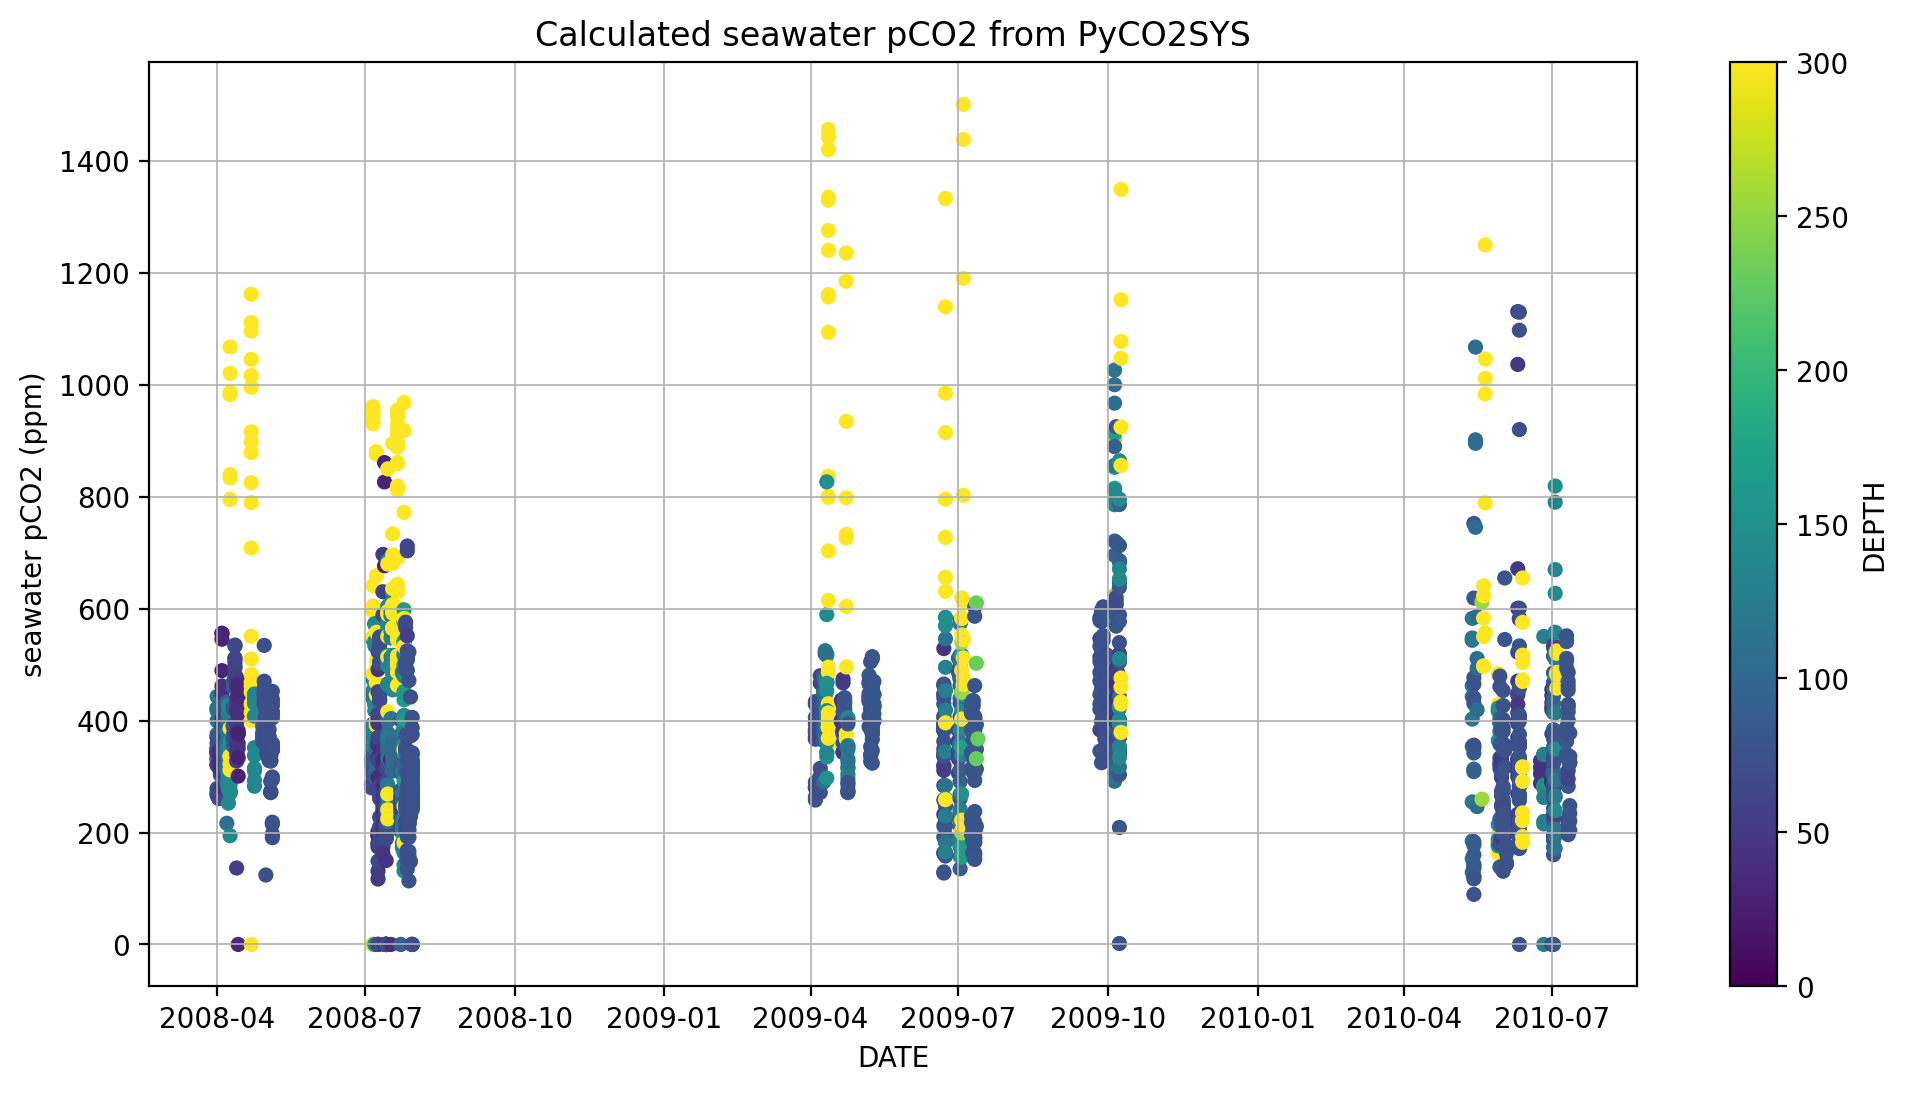

In [9]:
fig = plt.figure()
ax = dfbering.plot.scatter(x='DATE', y='CO2', c = 'DEPTH',  vmin = 0, vmax = 300)
ax.grid(which='major', linewidth='0.6')
ax.set_ylabel("seawater pCO2 (ppm)")
ax.set_title('Calculated seawater pCO2 from PyCO2SYS')

High latitude oceans are often carbon sinks, absorbing CO2 at quantities resulting in very high seawater pCO2. Depending on circulation and mixing patterns this is especially clear in deeper waters. The high variance in seawater pCO2, even at surface conditions is perhaps indicative of springtime biological uptake or lack thereof of CO2. Looking at the meridional and zonal spatial variations in nutrient concentrations could be helpful for determining some of the mechanisms behind this variance.

# Exploration of Alkalinity-Salinity and Alkalinity-Temp Space

The logic of ocean acidicification is that alkalinity serves to buffer pH that is forced lower by DIC addition. If alkalinity remains high, it is possible to maintain relatively steady pH values. The low pH decreases caco3 saturation state making it harder for organisms (like crabs) to utilize calcium carbonate in their growth.

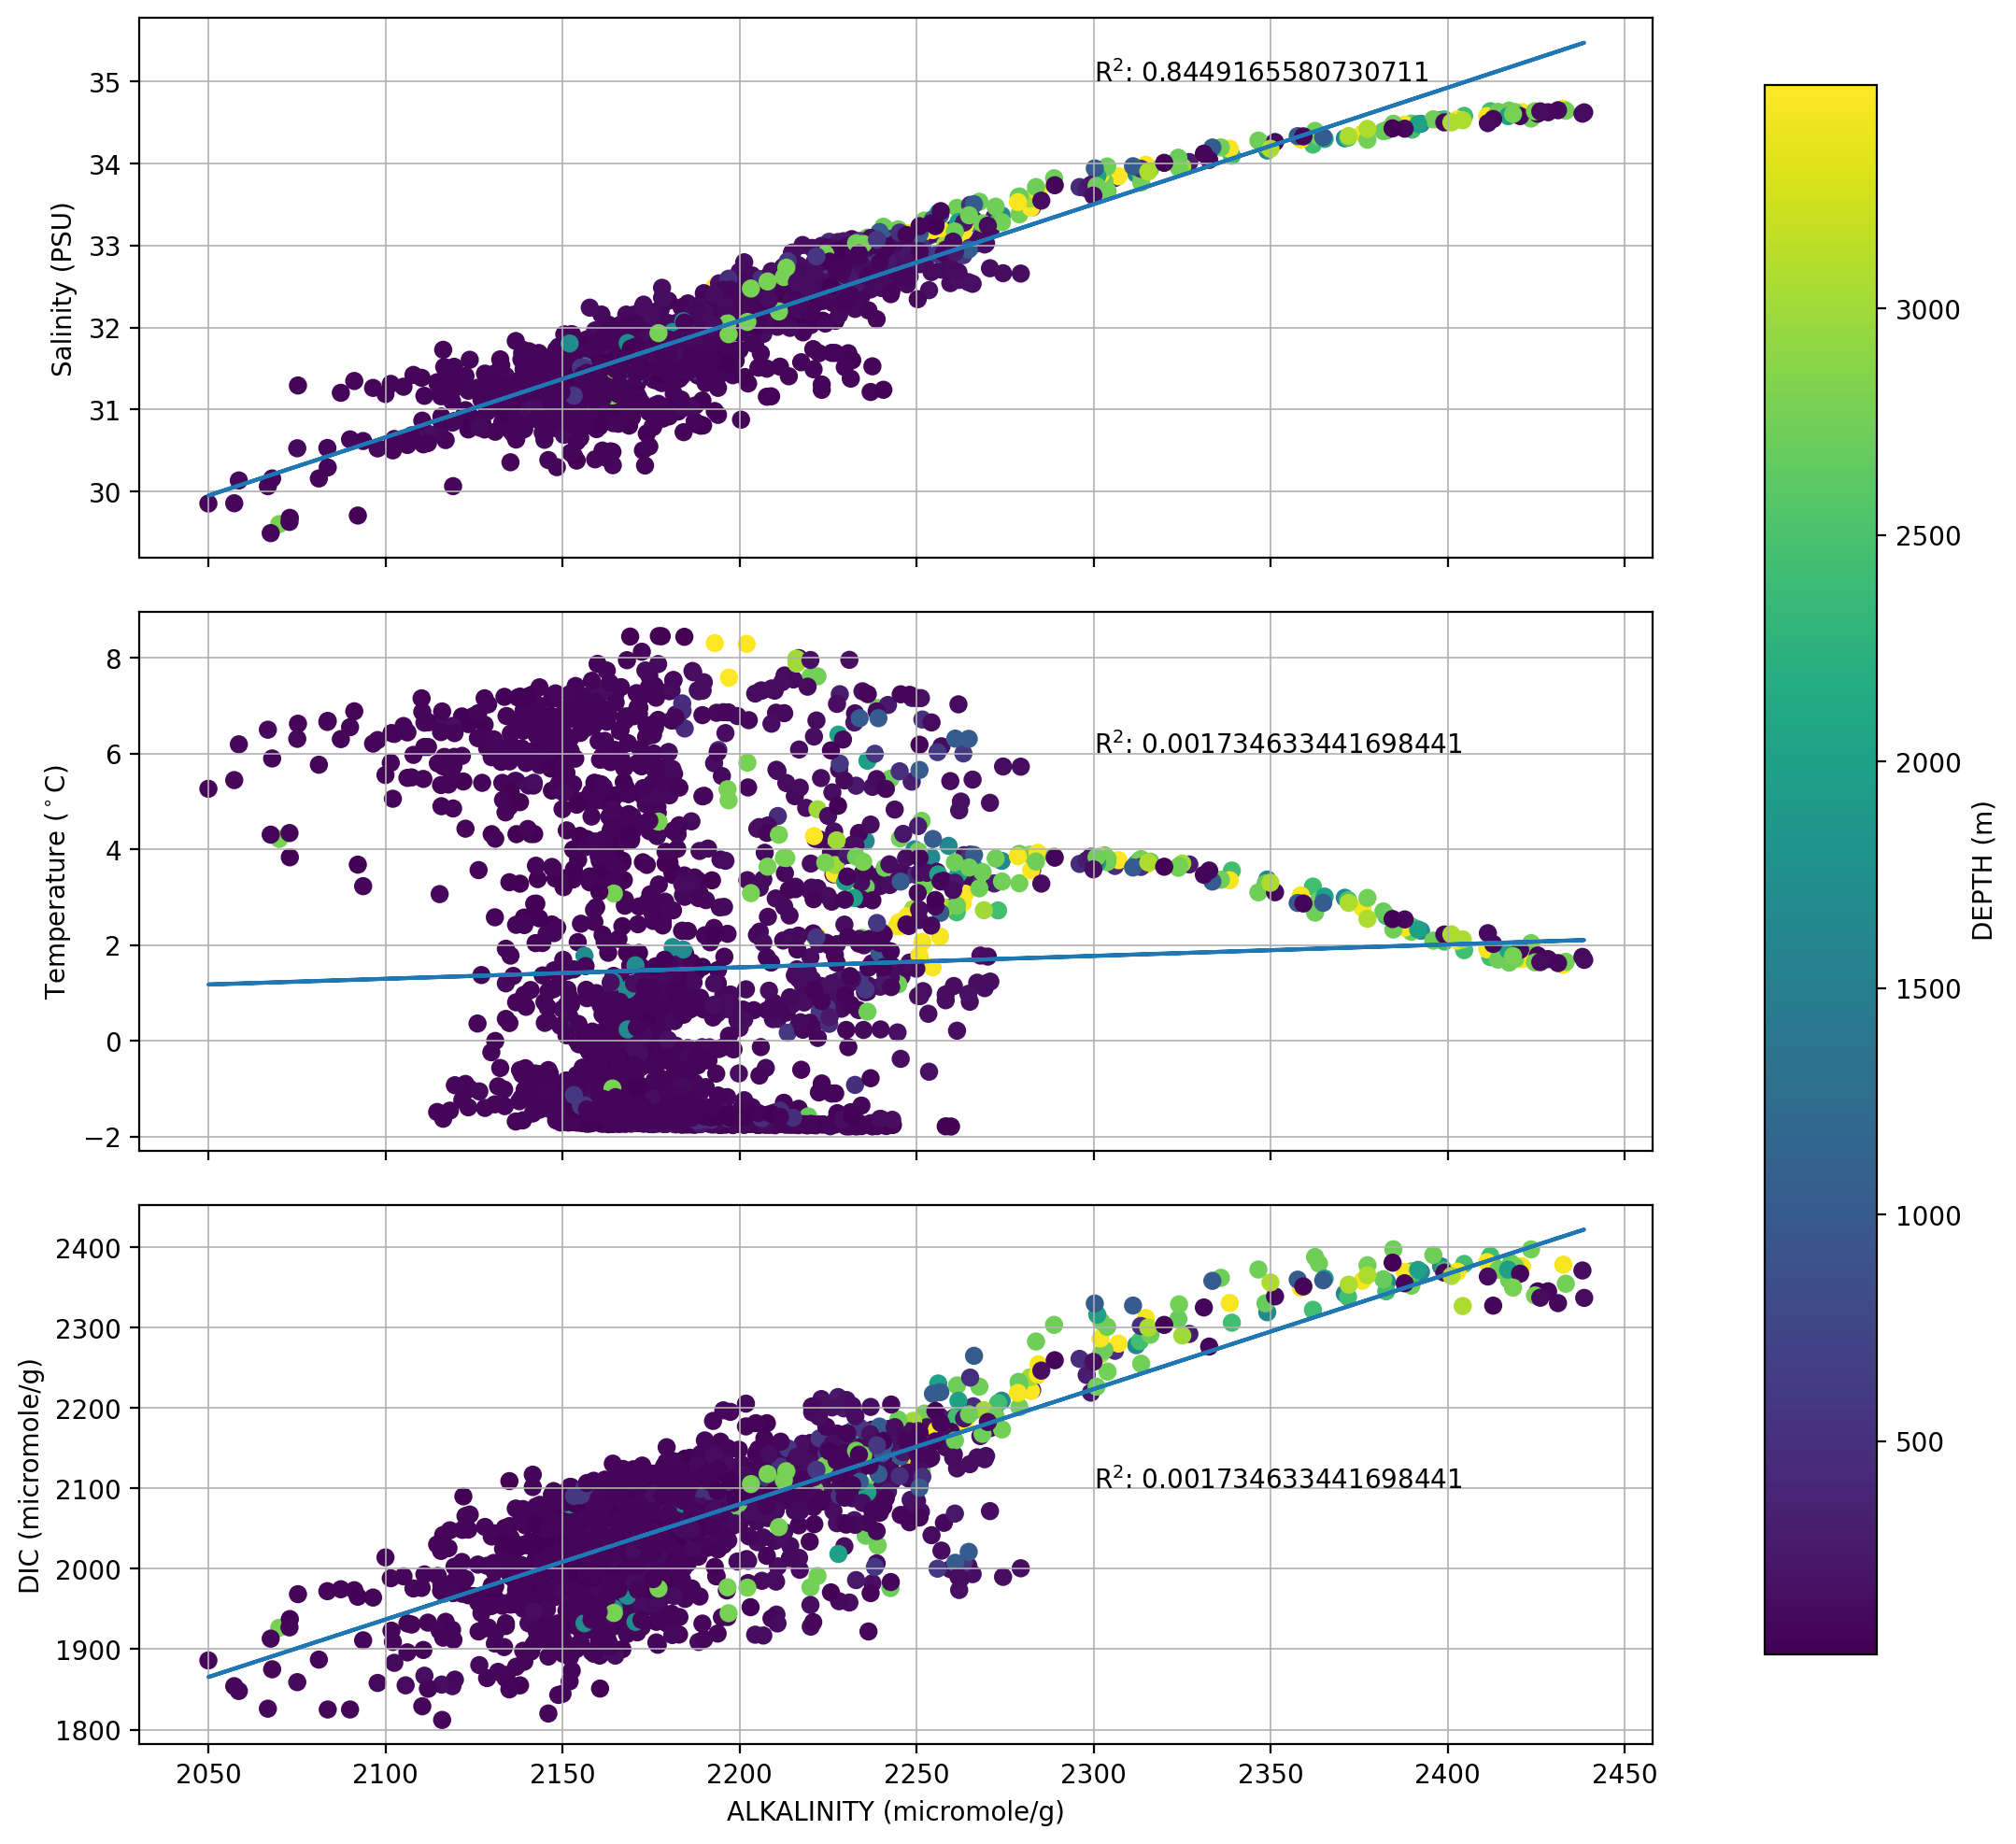

In [10]:
from sklearn.metrics import r2_score

fig, axes = plt.subplots(figsize=(12,12), nrows=3, sharex = True)
plt.subplots_adjust(wspace=0.0,hspace=0.1)
ax0, ax1, ax2, = axes

colors = ax0.scatter(x =  dfbering.ALKALI, y =  dfbering.CTDSAL, c=  dfbering.DEPTH)
ax0.grid(which='major', linewidth='0.6')
ax0.set_ylabel("Salinity (PSU)")
z = np.polyfit(dfbering.ALKALI, dfbering.CTDSAL, 1)
p = np.poly1d(z)
y_fit = np.polyval(z, dfbering.ALKALI)
r_squared = r2_score(dfbering.CTDSAL, y_fit)
ax0.plot(dfbering.ALKALI, p(dfbering.ALKALI))
ax0.annotate('R$^2$: ' + str(r_squared), (2300,35))

colors1 = ax1.scatter(x =  dfbering.ALKALI, y =  dfbering.CTDTMP, c=  dfbering.DEPTH)
ax1.grid(which='major', linewidth='0.6')
ax1.set_ylabel("Temperature ($^\circ$C)")
y = np.polyfit(dfbering.ALKALI, dfbering.CTDTMP, 1)
q = np.poly1d(y)
ax1.plot(dfbering.ALKALI, q(dfbering.ALKALI))
z_fit = np.polyval(y, dfbering.ALKALI)
r_squared1 = r2_score(dfbering.CTDTMP, z_fit)
ax1.annotate('R$^2$: ' + str(r_squared1), (2300,6))

colors2 = ax2.scatter(x =  dfbering.ALKALI, y =  dfbering.TCARBN, c=  dfbering.DEPTH)
ax2.grid(which='major', linewidth='0.6')
ax2.set_ylabel("DIC (micromole/g)")
ax2.set_xlabel("ALKALINITY (micromole/g)")
w = np.polyfit(dfbering.ALKALI, dfbering.TCARBN, 1)
r = np.poly1d(w)
ax2.plot(dfbering.ALKALI, r(dfbering.ALKALI))
w_fit = np.polyval(w, dfbering.ALKALI)
r_squared2 = r2_score(dfbering.TCARBN, w_fit)
ax2.annotate('R$^2$: ' + str(r_squared1), (2300,2100))


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, .05, .70])
fig.colorbar(colors, label = 'DEPTH (m)', use_gridspec = True, pad =.1, cax=cbar_ax)

These plots confirm my decision to remove deeper samples from the dataset for further analysis. The deeper ocean appears to be acting distinctly from the surface, this is perhaps due to positonioning further west, out away from shallow shelf waters. These deep CO2 rich waters are also not likely to be inhabited by the larva that are more sensitive to changes in pH.

# Comparison to Mauna Loa CO2 Curve

Comparison to the Mauna Loa atmospheric CO2 "Keeling" curve from 2008-2010 provides a little bit of a check on the calculated seawater pCO2, lends insight as to whether it seems like this region acts as a carbon sink or source.

In [11]:
bering_shallow = dfbering[dfbering.DEPTH < 300]

In [12]:
co2_mlo= pd.read_csv('co2_daily_mlo.csv', skiprows=[0])
co2_mlo['Date'] = pd.to_datetime(dict(year=co2_mlo.Year, month=co2_mlo.Month, day=co2_mlo.Day))
co2_mlo = co2_mlo[(co2_mlo.Year > 2007) & (co2_mlo.Year < 2011)]
print(co2_mlo.head())

bering_shallowx= xr.Dataset.from_dataframe(bering_shallow.set_index(['DATE']).sort_index())
co2_mlox= xr.Dataset.from_dataframe(co2_mlo.set_index(['Date']))

       Year  Month  Day       Date     Co2
10034  2008      1    1 2008-01-01  385.30
10035  2008      1    2 2008-01-02  385.49
10036  2008      1    3 2008-01-03  384.97
10037  2008      1    4 2008-01-04  384.67
10038  2008      1    5 2008-01-05  384.72


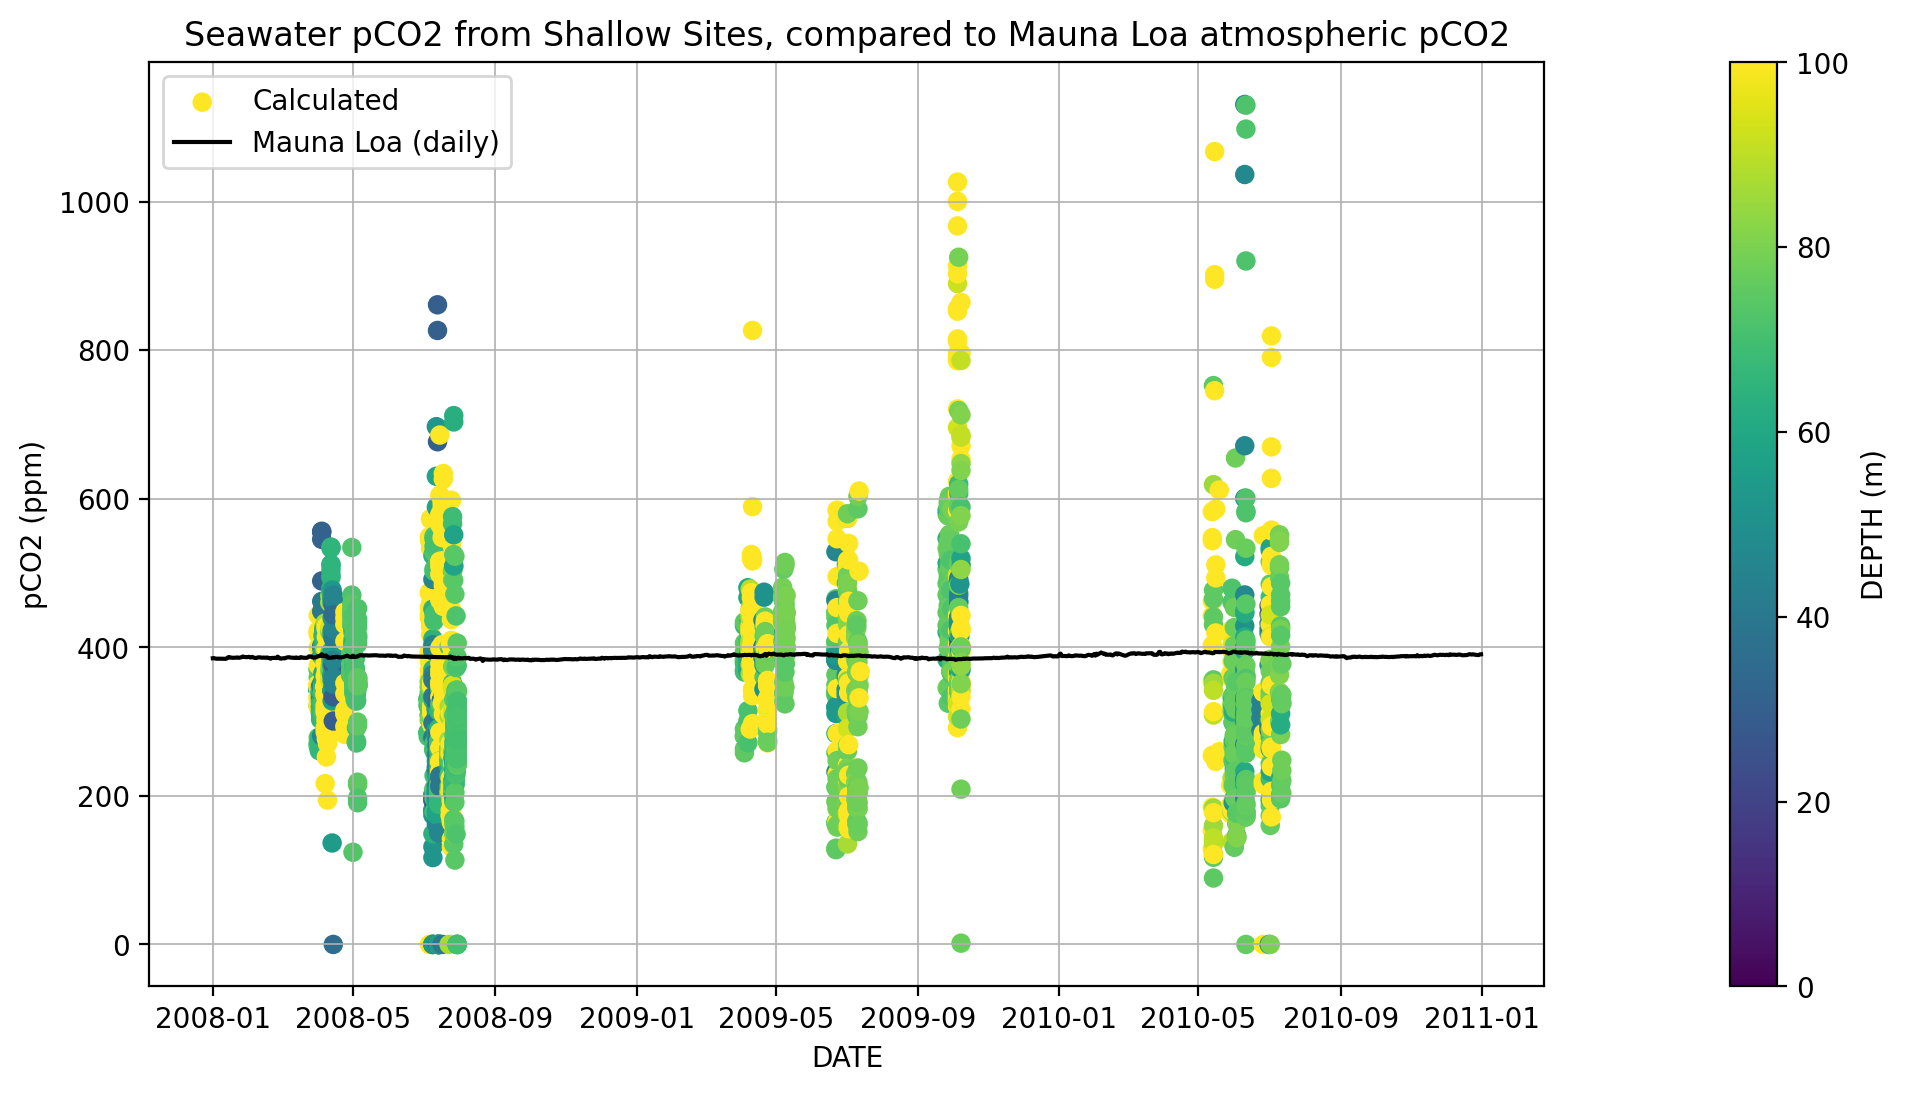

In [13]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
shallow = ax.scatter(bering_shallowx.DATE, bering_shallowx.CO2, c = bering_shallowx.DEPTH, vmin = 0, vmax = 100 )
ax.plot(co2_mlox.Date, co2_mlox.Co2, color = 'black')
plt.colorbar(shallow, label = 'DEPTH (m)', use_gridspec = True, pad =.1)
ax.grid(which='major', linewidth='0.6')
ax.set_ylabel("pCO2 (ppm)")
ax.set_xlabel("DATE")
ax.set_title("Seawater pCO2 from Shallow Sites, compared to Mauna Loa atmospheric pCO2")
ax.legend(["Calculated", "Mauna Loa (daily)"])

Even at shallow depths, we see a wide range in values. The continental shelf that lies under the bering sea is shallow; between 100-200 meters deep. Since the Bering Sea is highly stratified during the summer

In [14]:
bering_shallowgb = bering_shallowx.groupby('DATE')
bering_meanx= bering_shallowgb.mean()

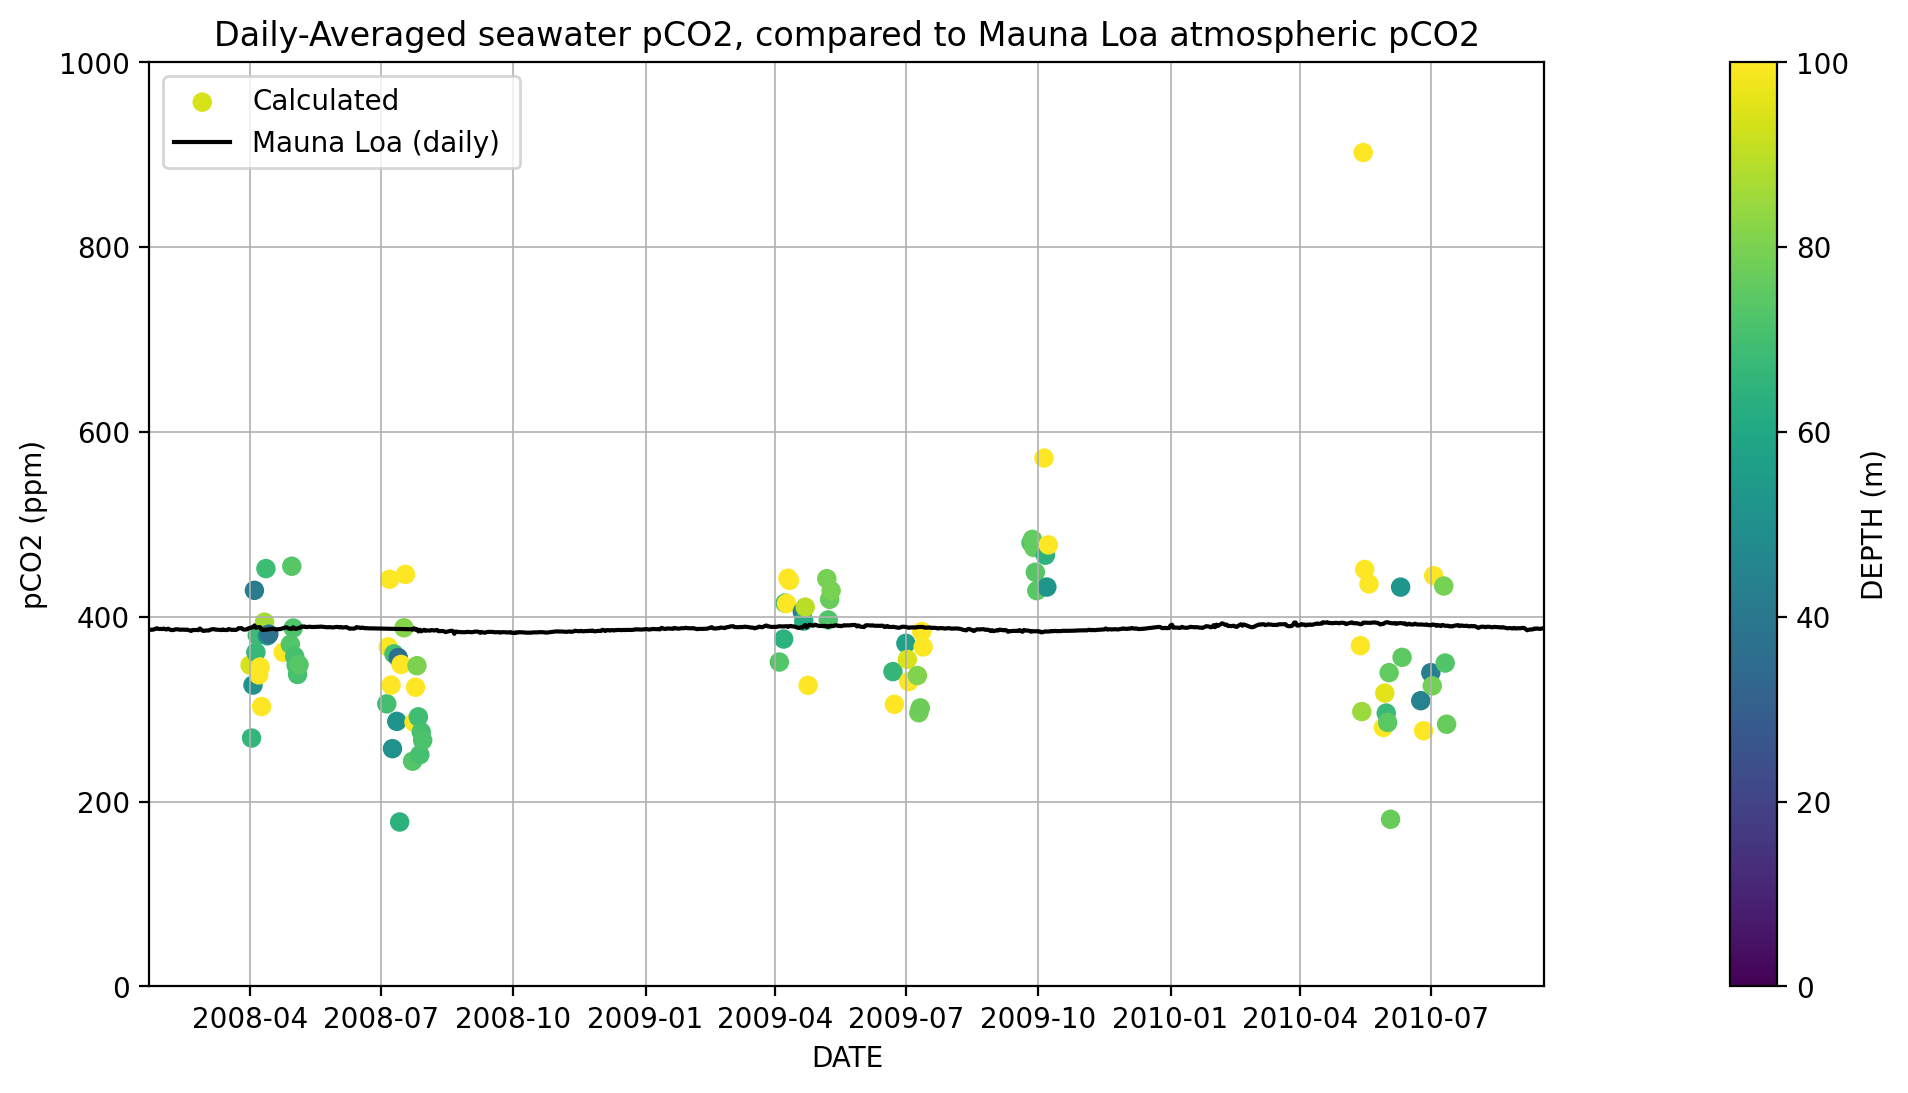

In [15]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
mean = ax.scatter(bering_meanx.DATE, bering_meanx.CO2, c = bering_meanx.DEPTH, vmin = 0, vmax = 100)
ax.plot(co2_mlox.Date, co2_mlox.Co2, color = 'black')
ax.set_ylim(0, 1000)
ax.set_xlim(13900, 14870)
plt.grid(which='major', linewidth='0.6')
plt.colorbar(mean, label = 'DEPTH (m)', use_gridspec = True, pad =.1)
ax.set_ylabel("pCO2 (ppm)")
ax.set_xlabel("DATE")
ax.set_title("Daily-Averaged seawater pCO2, compared to Mauna Loa atmospheric pCO2")
ax.legend(["Calculated", "Mauna Loa (daily) "])

After averging, our data is roughly clustered around the Keeling Curve, with higher seawater pCO2 observed from the october cruise. And lower seawater pCO2 observed on the July cruises.

# Crab Catch Analysis

The fisheries crab dataset is large, detailing the CPUE (Catch per Unit Effort) for 6 economically important species of crab. CPUE is the variable I use in my analysis as a proxy for crab biomass. I only use 3 of those species in my final analysis, the Red King Crab, Blue King Crab, and the Hybrid Tanner Crab. Red King Crabs are thought to be more resistent to decreases in pH than Blue King Crabs and Hybrid Tanner Crabs. A caveat to this approach is that the assumption catch to be directly proportional to biomass. My approach also does not really account for migration of species, spatial distribution, or for regulations and restrictions on catch quantities.

In [16]:
species = crabstudy.groupby('COMMON_NAME')
red_king = species.get_group('red king crab')
blue_king = species.get_group('blue king crab')
snow = species.get_group('snow crab')
hybrid_tanner = species.get_group('hybrid Tanner crab')

In [17]:
red_kingx = xr.Dataset.from_dataframe(red_king)
red_king_monthly = red_kingx.resample(DATE ='ME').sum()
blue_kingx = xr.Dataset.from_dataframe(blue_king)
blue_king_monthly = blue_kingx.resample(DATE ='ME').sum()
hybrid_tannerx = xr.Dataset.from_dataframe(hybrid_tanner)
hybrid_tanner_monthly = hybrid_tannerx.resample(DATE ='ME').sum()
snowx = xr.Dataset.from_dataframe(snow)

Text(0.5, 1.0, 'Crab CPUE by Species')

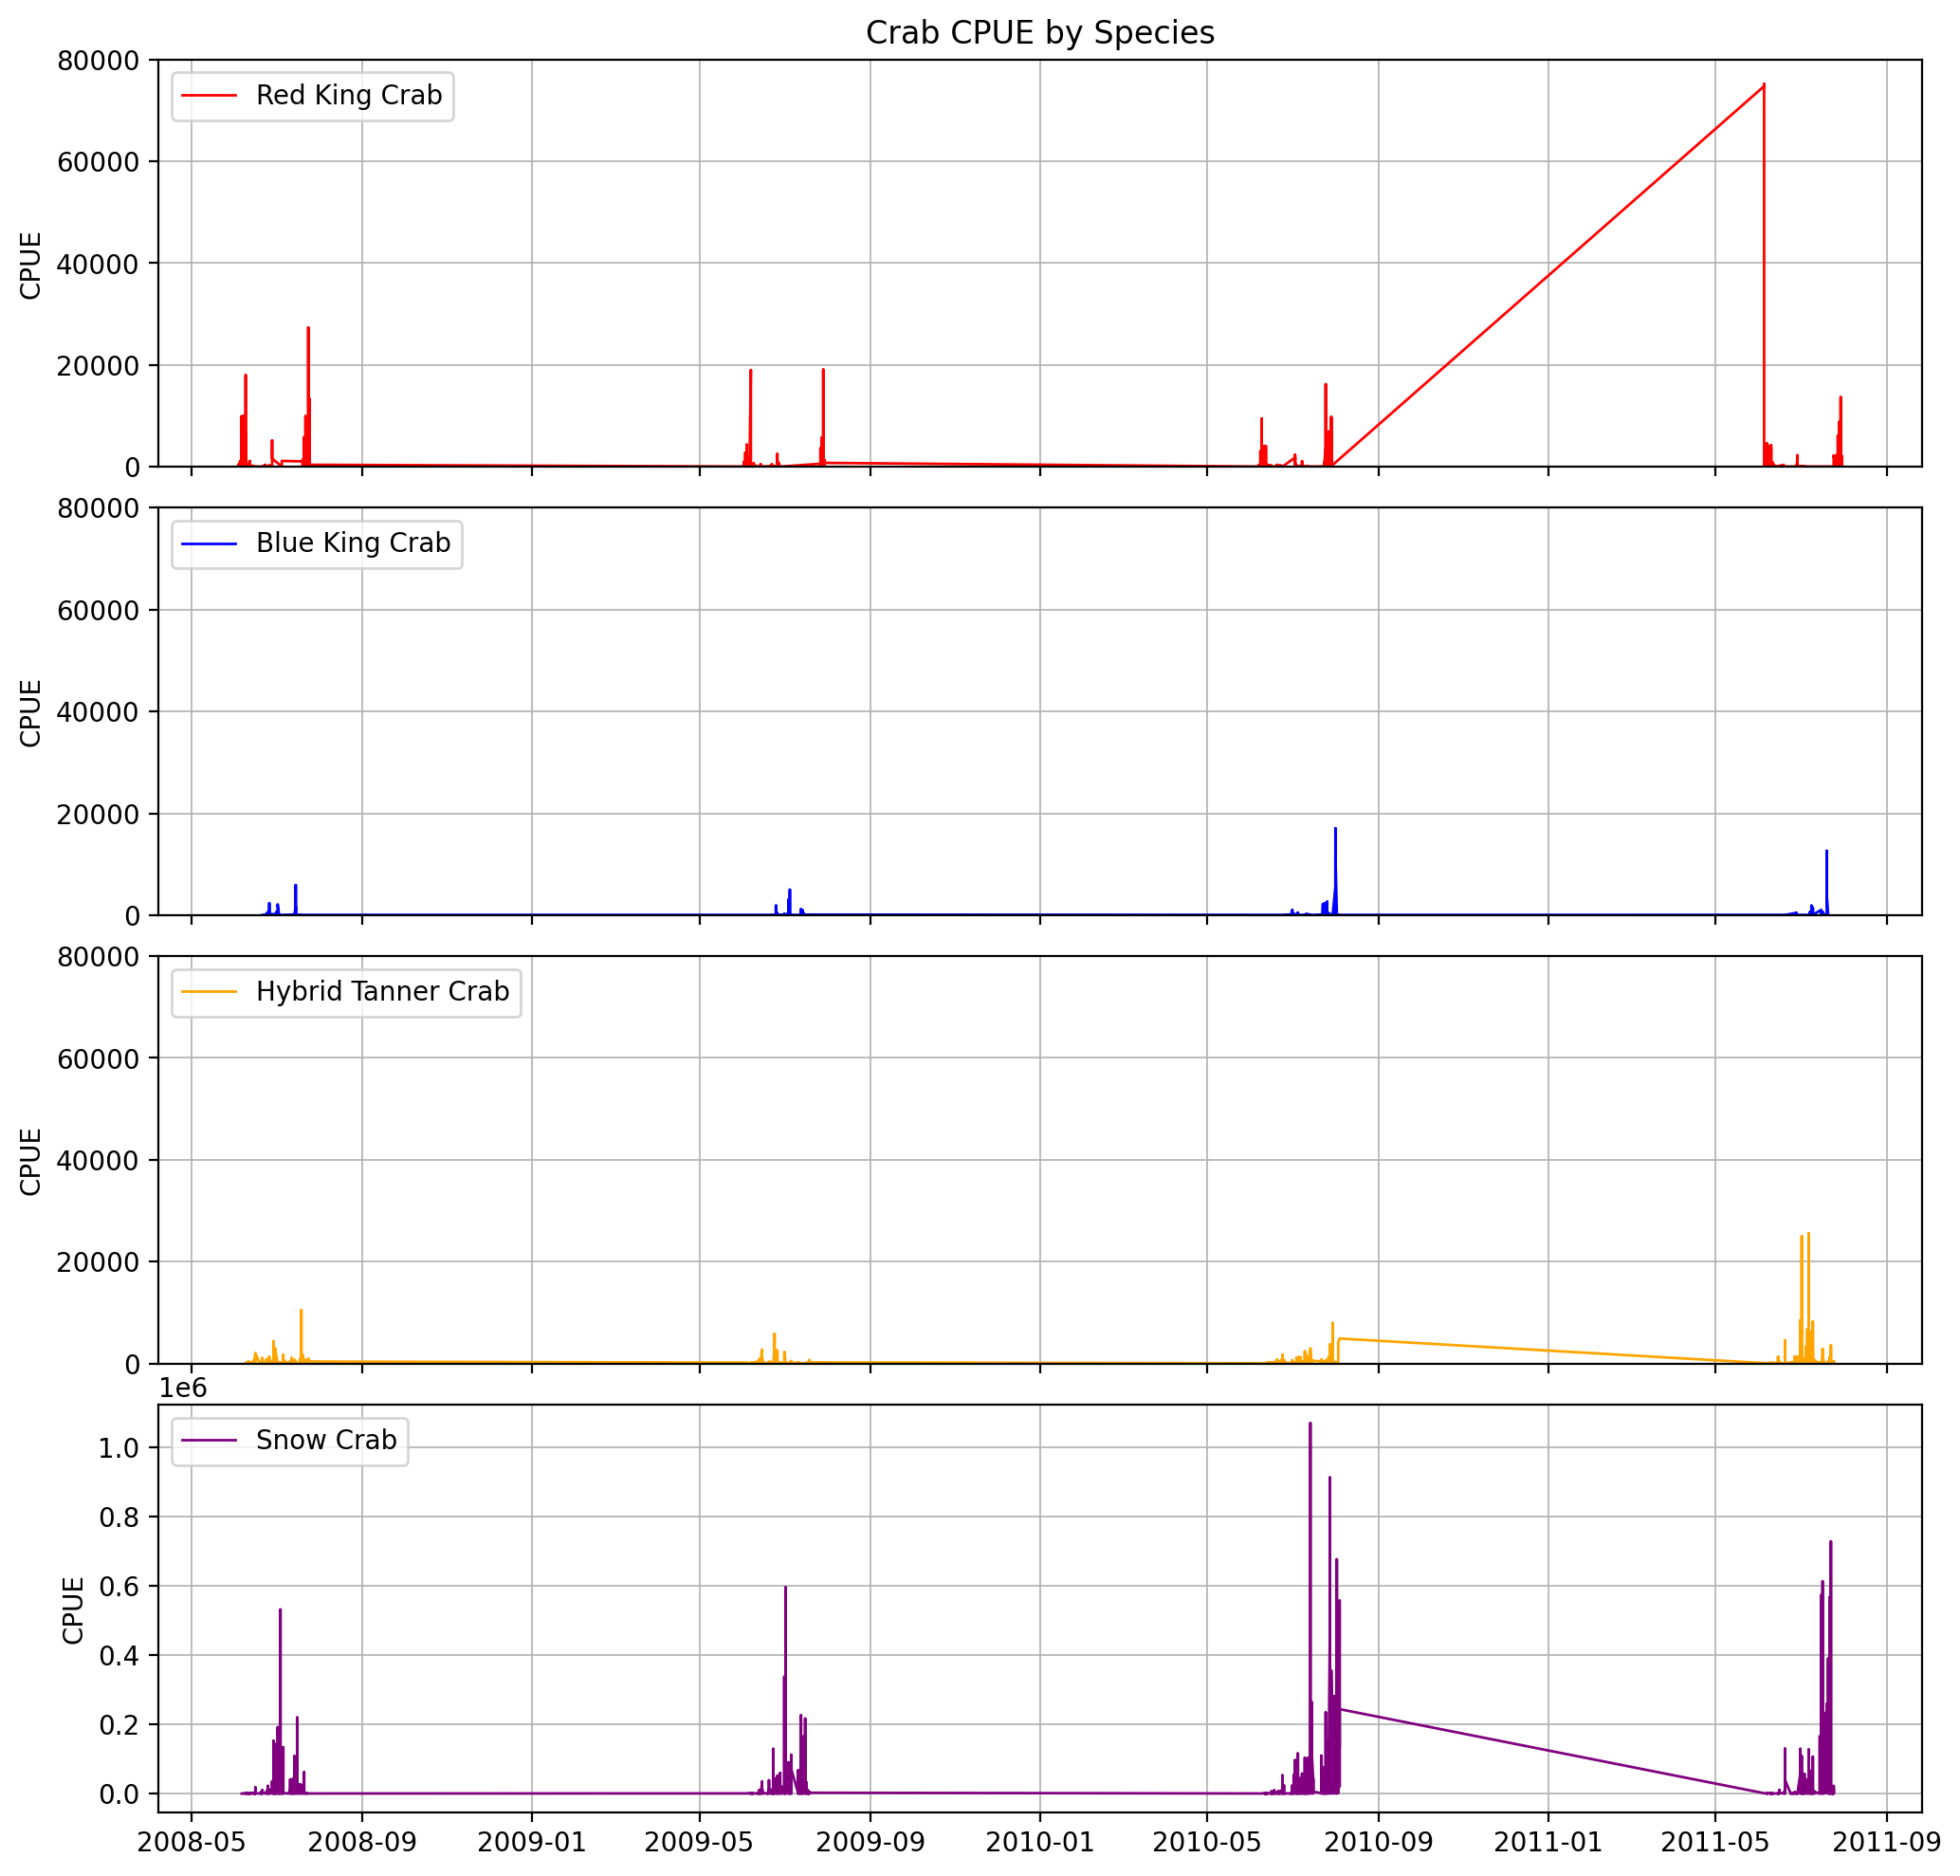

In [18]:
fig, axes = plt.subplots(figsize=(12,12), nrows=4, sharex = True)
plt.subplots_adjust(wspace=0.0,hspace=0.1)
ax0, ax1, ax2, ax3 = axes
ax0.plot(red_kingx.DATE, red_kingx.CPUE, color='red', linewidth=1)
ax0.grid(which='major', linewidth='0.6')
ax0.tick_params(axis='y', labelsize=10)
ax0.set_ylabel('CPUE', fontsize=10)
ax0.set_ylim(0, 80000)
ax0.legend(["Red King Crab", "range"], loc="upper left", fontsize=10)

ax1.plot(blue_kingx.DATE, blue_kingx.CPUE, color='blue', linewidth=1)
ax1.grid(which='major', linewidth='0.6')
ax1.tick_params(axis='y', labelsize=10)
ax1.set_ylabel('CPUE', fontsize=10)
ax1.set_ylim(0, 80000)
ax1.legend(["Blue King Crab"], loc="upper left", fontsize=10)

ax2.plot(hybrid_tannerx.DATE, hybrid_tannerx.CPUE, color='orange', linewidth=1)
ax2.grid(which='major', linewidth='0.6')
ax2.tick_params(axis='y', labelsize=10)
ax2.set_ylabel('CPUE', fontsize=10)
ax2.set_ylim(0, 80000)
ax2.legend(["Hybrid Tanner Crab"], loc="upper left", fontsize=10)

ax3.plot(snowx.DATE, snowx.CPUE, color='purple', linewidth=1)
ax3.grid(which='major', linewidth='0.6')
ax3.tick_params(axis='y', labelsize=10)
ax3.set_ylabel('CPUE', fontsize=10)
ax3.legend(["Snow Crab"], loc="upper left", fontsize=10)

ax0.set_title('Crab CPUE by Species')

Note the scale, where snow crab CPUE is 10^2 greater than the other species. Red King crab exhibits two peaks per year, likely a relic of fishery regulations, restricitions, and openings.

In [19]:
bering_monthly = bering_shallowx.resample(DATE ='ME').mean(dim = 'DATE')

Text(0.5, 1.0, 'Monthly Averaged pH from April 2008 to August 2010')

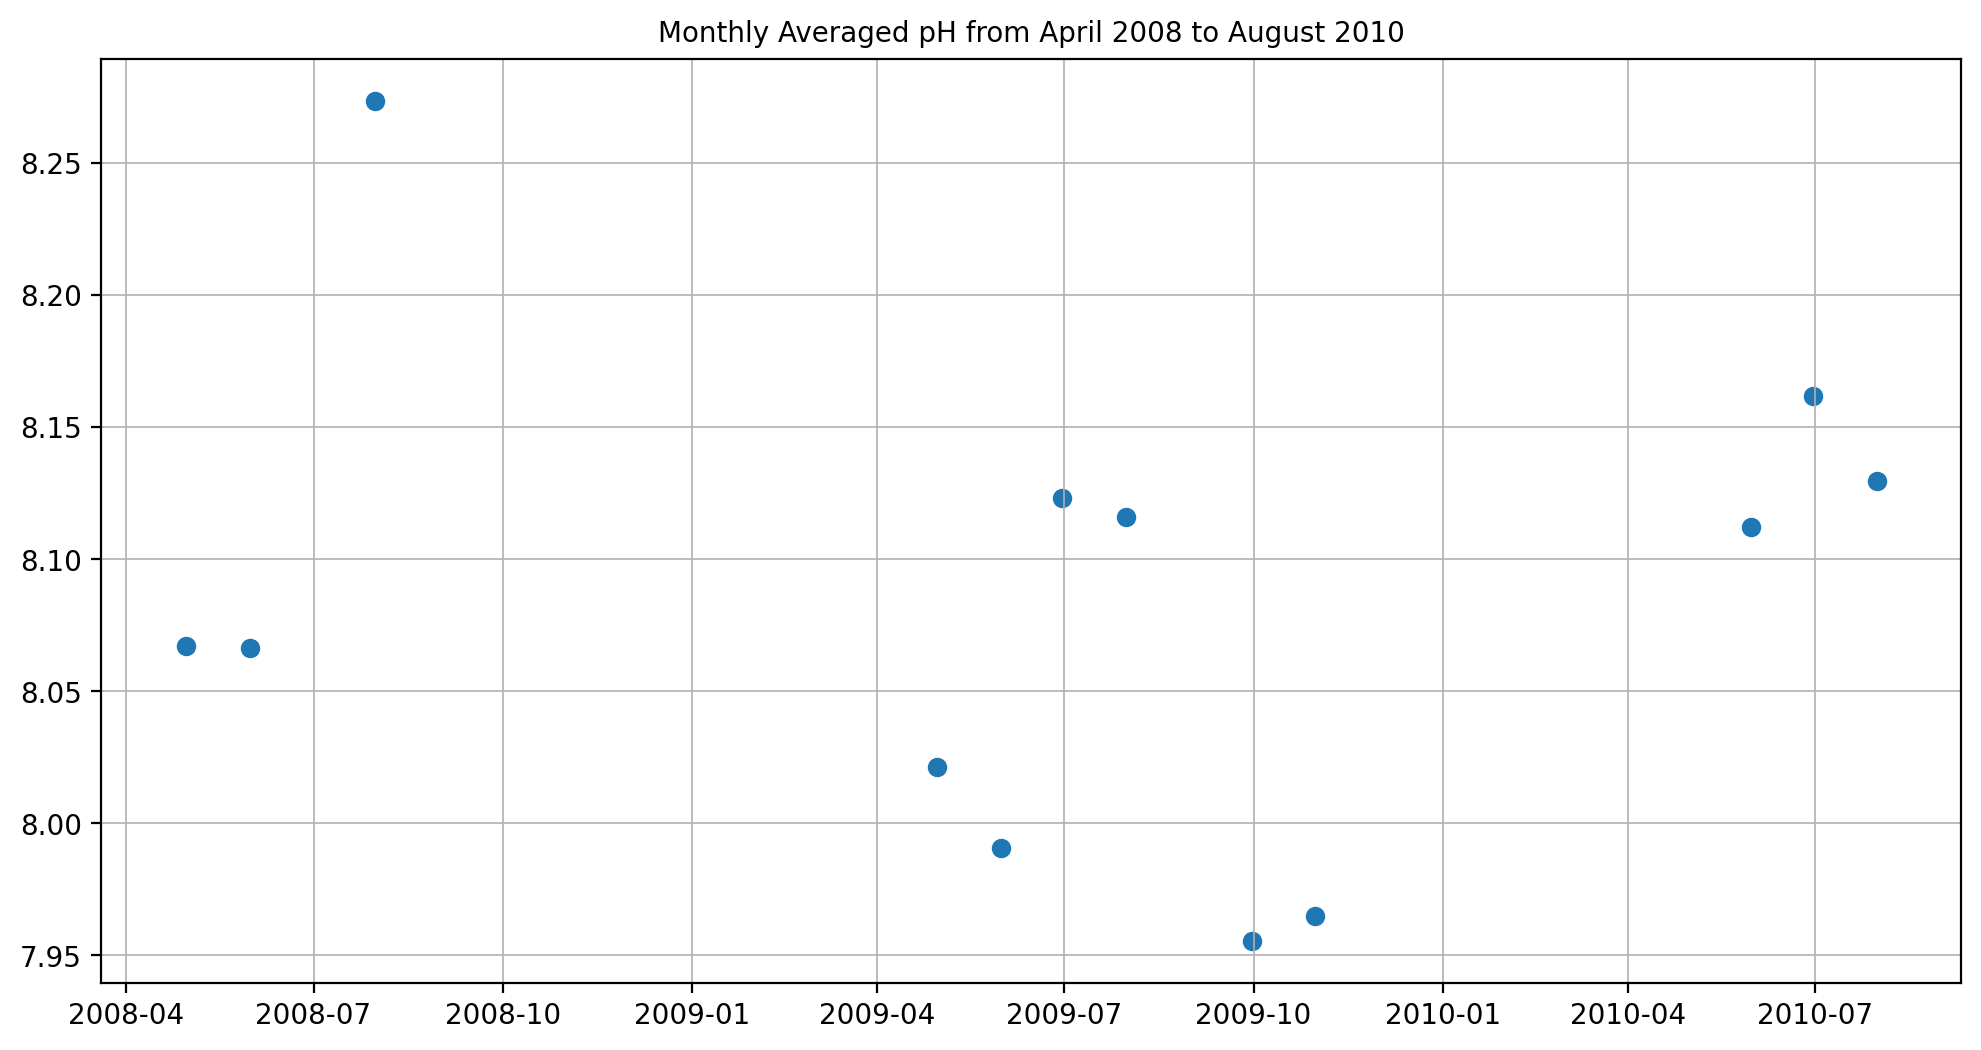

In [20]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.scatter(x= bering_monthly.DATE, y = bering_monthly.pH)
ax.grid(which='major', linewidth='0.6')
ax.grid(which='minor', linestyle='--')
ax.set_title('Monthly Averaged pH from April 2008 to August 2010', fontsize=10)

Text(0.5, 1.0, 'CPUE Monthly SUM for three species of Crab from the East Bering Sea')

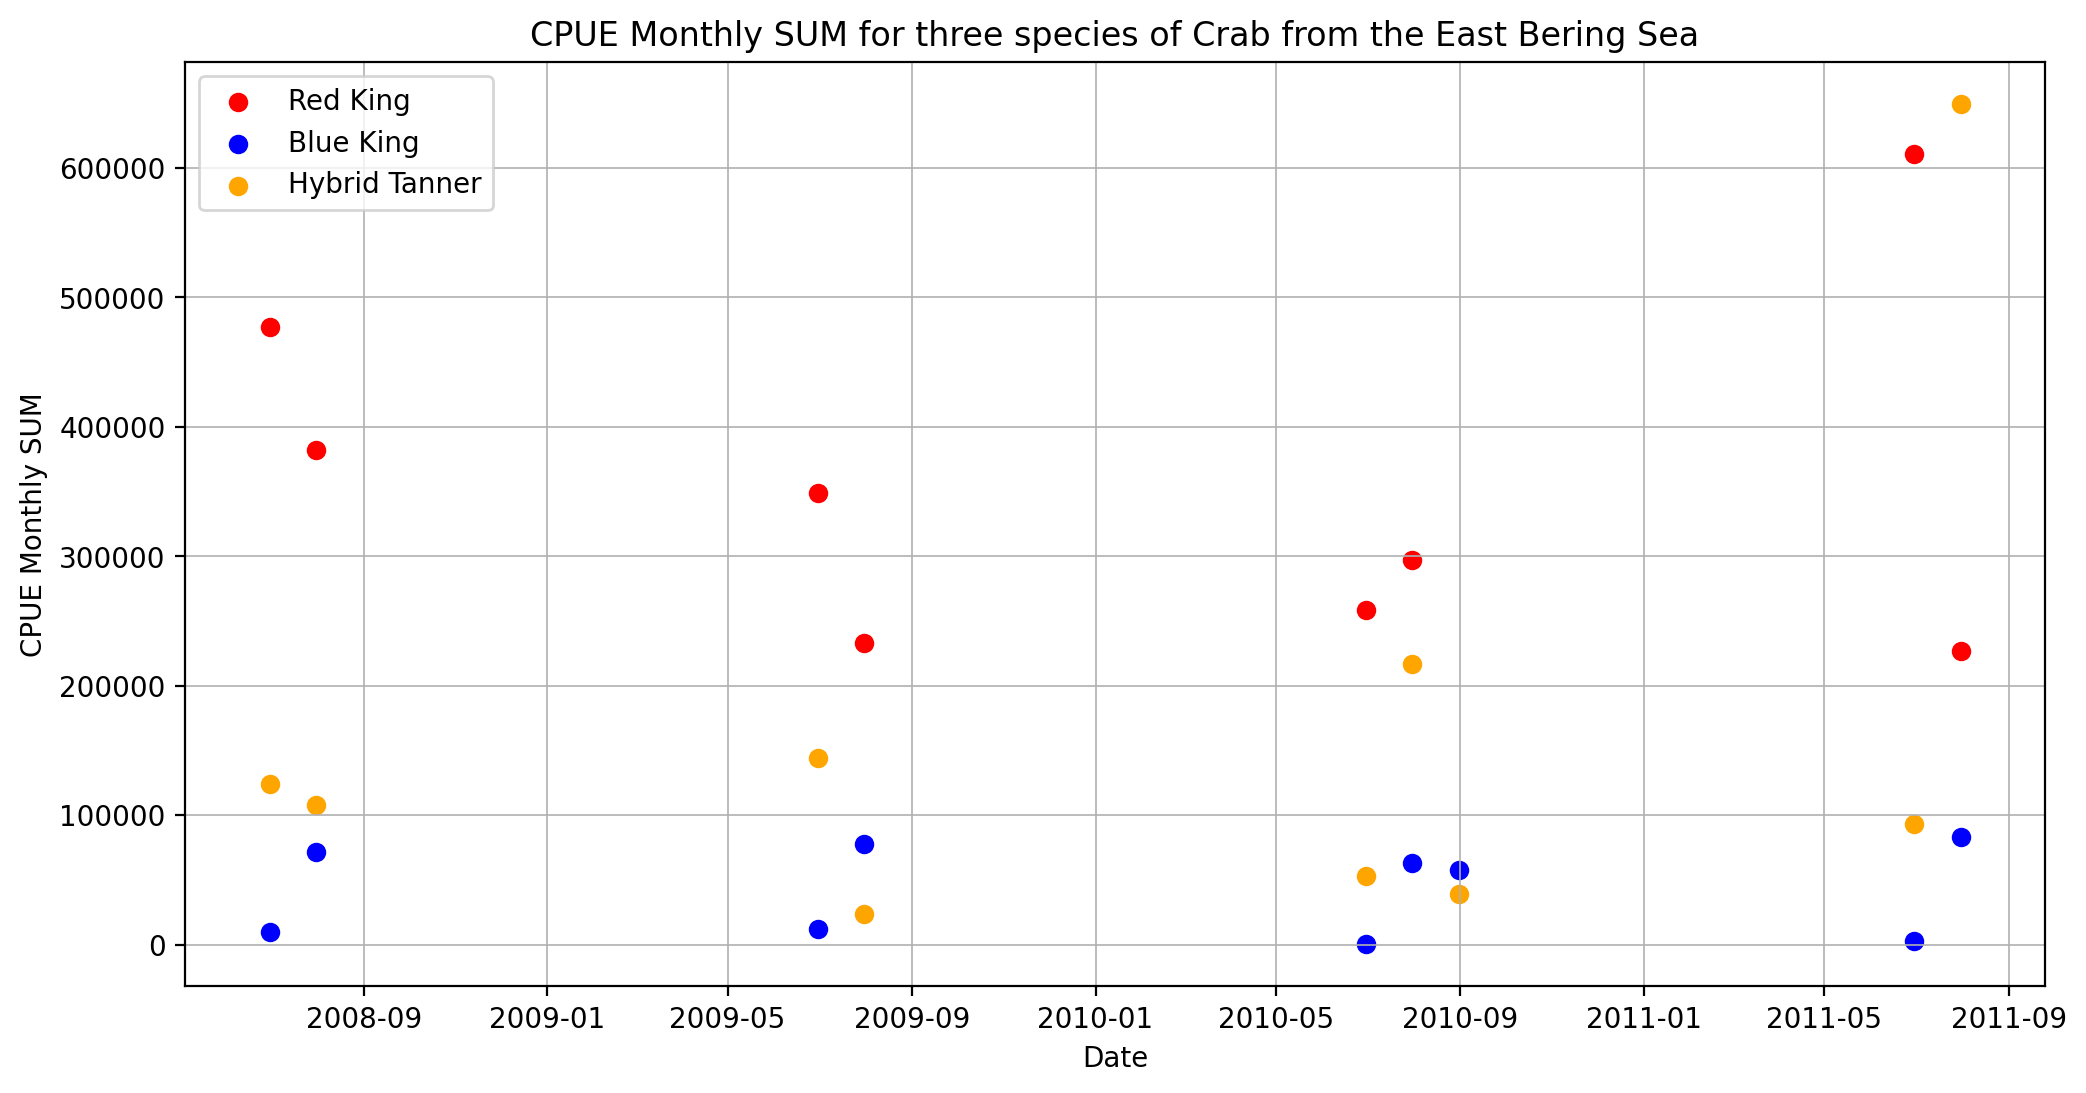

In [21]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.scatter(x= red_king_monthly.DATE, y = red_king_monthly.CPUE, color = 'red')
ax.scatter(x= blue_king_monthly.DATE, y = blue_king_monthly.CPUE, color ='blue')
ax.scatter(x= hybrid_tanner_monthly.DATE, y = hybrid_tanner_monthly.CPUE, color='orange')
ax.set_ylabel("CPUE Monthly SUM")
ax.set_xlabel("Date")
ax.legend(["Red King", "Blue King", "Hybrid Tanner"], loc = 'upper left')
ax.grid(which='major', linewidth='0.6')
ax.grid(which='minor', linestyle='--')
ax.set_title('CPUE Monthly SUM for three species of Crab from the East Bering Sea')

I summed the CPUE data instead of averaging, beacuse I felt like that type of aggregation is more representative of the dataset, and gets rid of some of the human factors that could impact catch per unit effort eg, not being able to go out in storms. Aside from one outlier, there appears to be a decrease in red king crab CPUE over the time scale of my study, and little change in Tanner Crab CPUE.

# Trends in CPUE with Respect to pH

In order to plot and interpret CPUE with respect to pH, I need to make some assumptions:
I assume that would be no delay between pH fluctuation and crab CPUE response (this is likely not the case), I assume that spatial and temporal variations are not so extreme when I sum the entire dataset.

In [22]:
rk_cpue = red_king_monthly.CPUE
bk_cpue = blue_king_monthly.CPUE
ht_cpue = hybrid_tanner_monthly.CPUE

In [23]:
bering_monthly['RKCPUE'] = rk_cpue
bering_monthly['BKCPUE'] = bk_cpue
bering_monthly['HTCPUE'] = ht_cpue

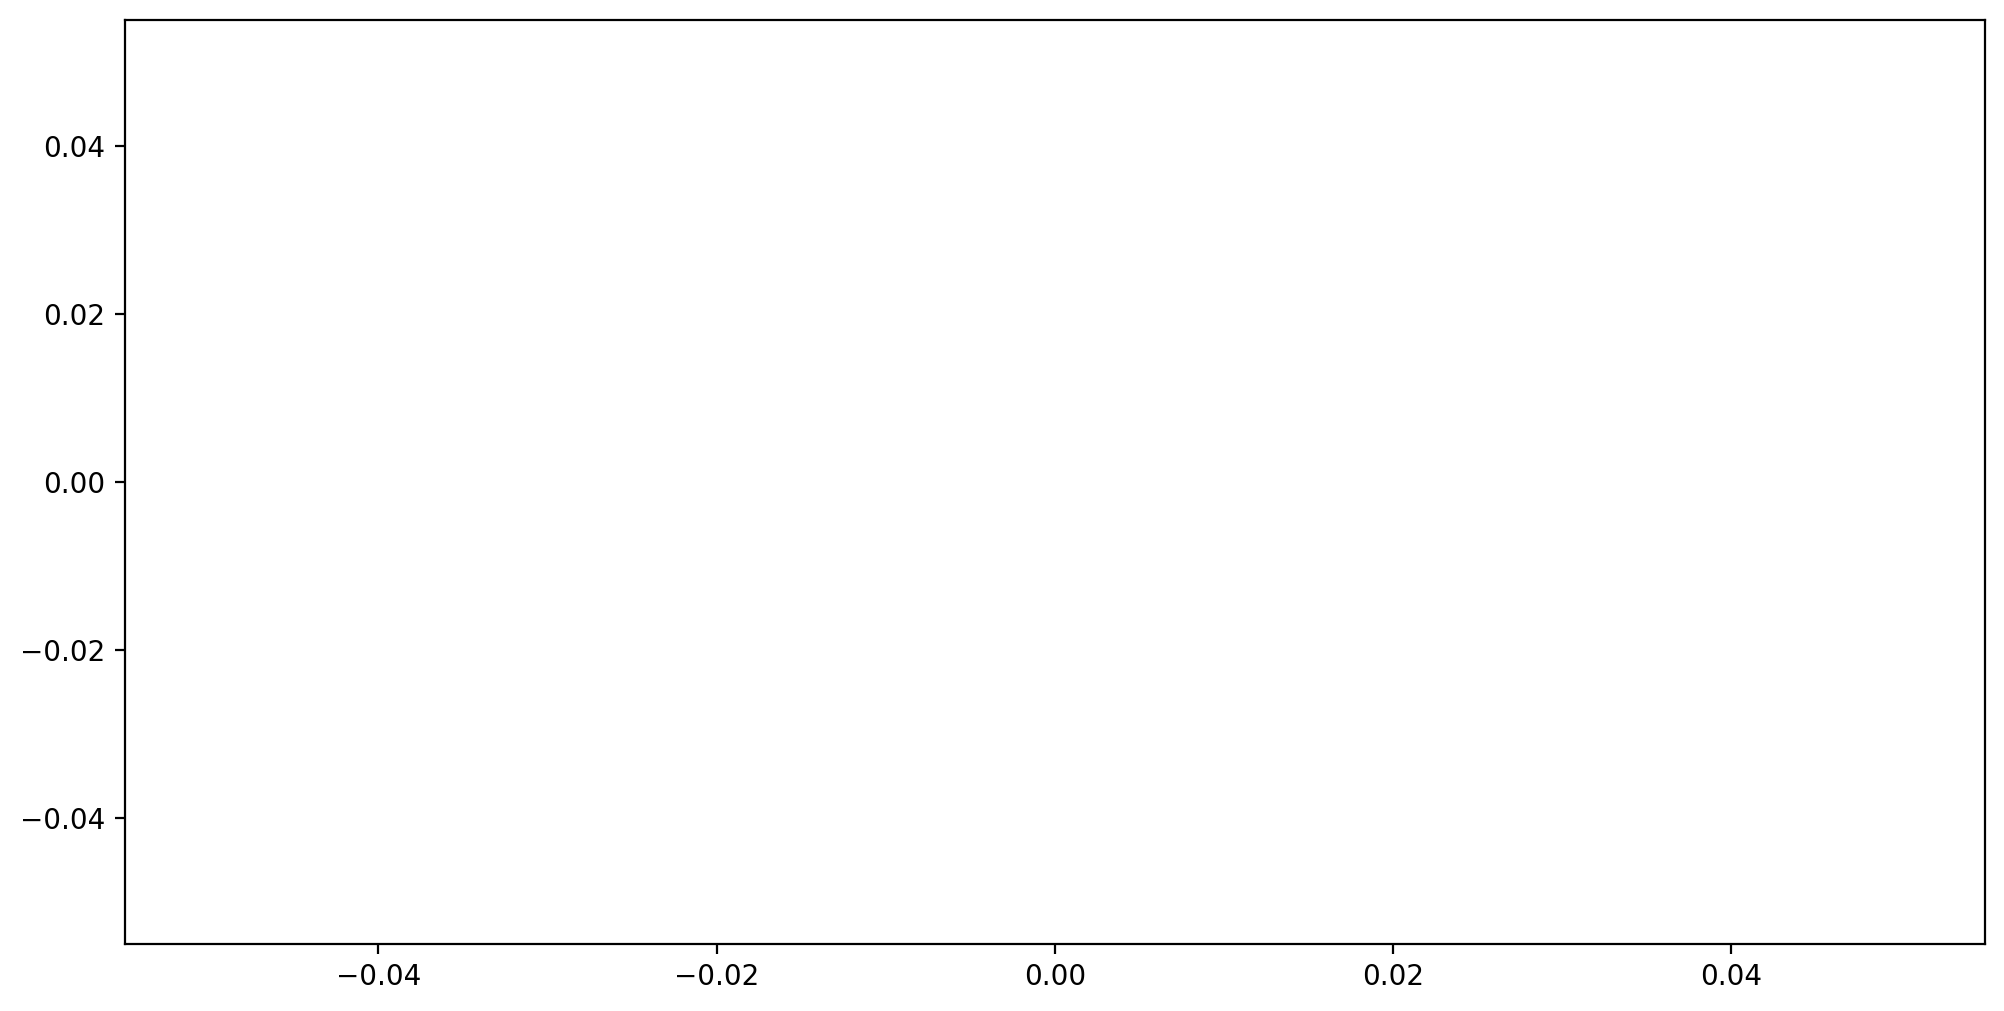

In [24]:
rk_da = bering_monthly.RKCPUE.to_numpy()
bk_da = bering_monthly.BKCPUE.to_numpy()
ht_da = bering_monthly.HTCPUE.to_numpy()
ph_da = bering_monthly.pH.to_numpy()

z = np.polyfit(rk_da[~np.isnan(rk_da)], ph_da[~np.isnan(rk_da)], 1)
p = np.poly1d(z)

plt.plot(rk_da, p(rk_da))

Text(0.5, 1.0, 'Monthly SUM CPUE crossplotted with pH for 3 crab species in the East Bering Sea')

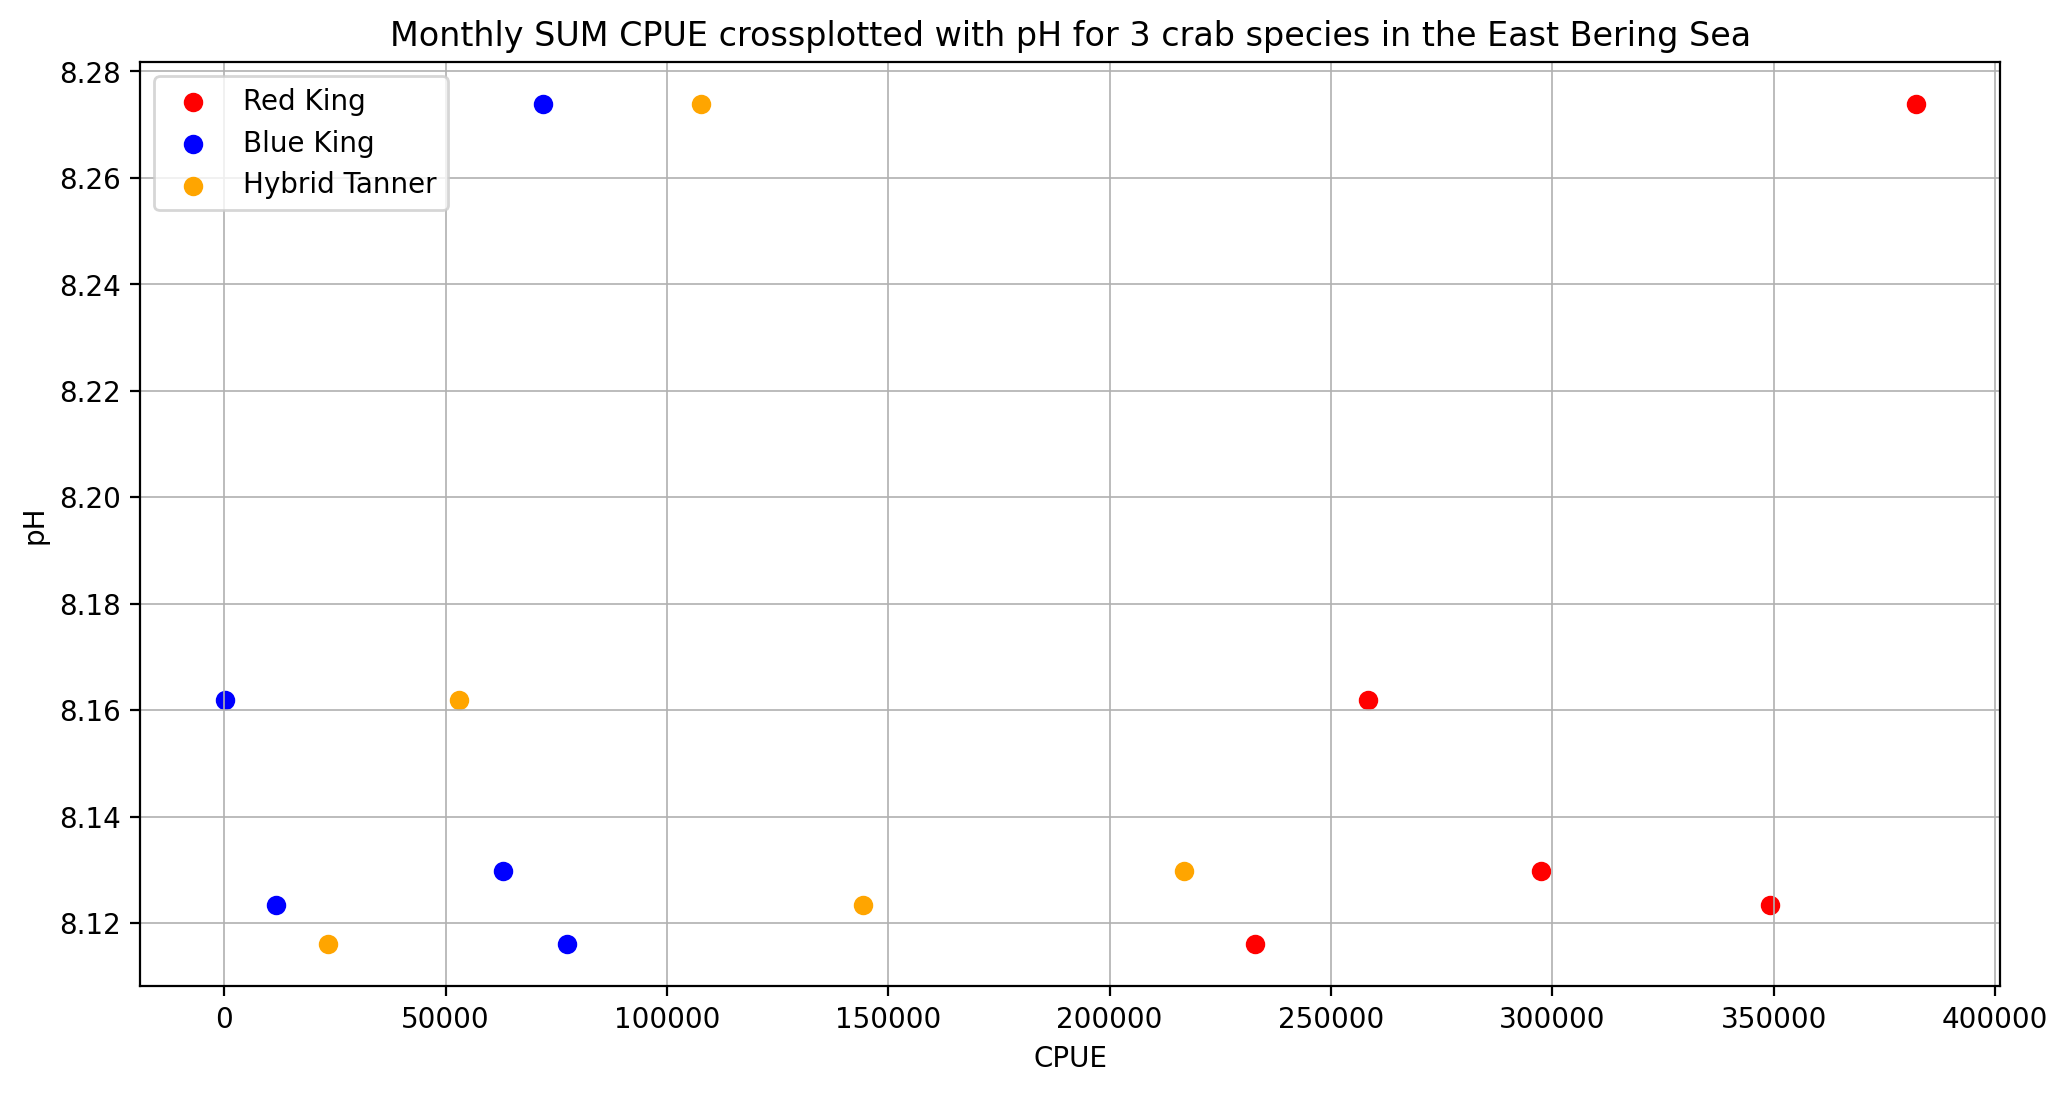

In [25]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.scatter(x = bering_monthly.RKCPUE, y = bering_monthly.pH, color = 'red')
ax.scatter(x = bering_monthly.BKCPUE, y = bering_monthly.pH, color = 'blue')
ax.scatter(x = bering_monthly.HTCPUE, y = bering_monthly.pH, color = 'orange')
ax.legend(["Red King", "Blue King", "Hybrid Tanner"], loc = 'upper left')
ax.grid(which='major', linewidth='0.6')
ax.grid(which='minor', linestyle='--')
ax.set_xlabel('CPUE', fontsize=10)
ax.set_ylabel('pH', fontsize=10)
ax.set_title('Monthly SUM CPUE crossplotted with pH for 3 crab species in the East Bering Sea')

# Conclusion and Reflection

Acidity and related parameters indeed exhibit a wide degree of variance in this region, the mechanisms causing this are complex and hard to pin down without further analysis.

It is difficult to elucidate an intepretation for crab population response to acididty off of what ended up being 5 data points. No trend is present in the data. I believe this project is confounded by timescale and sampling issue. Additionally, more recent work [in preprint](https://www.biorxiv.org/content/10.1101/2023.10.02.560246v1.full) has found that some of these species are more resilent to acidification than previously thought.

The shipboard profile samples contain high amounts of variability, and I struggle to tell what is signal and what is noise in reference to my driving research questions. To investigate the mechanisms and pararmeters forcing population fluctuations, it would be wise to look at the entire dataset. I am excited to learn more sophisticated analytical techniques that I could use to tease more information out of this rich, yet sparse dataset.

## Potential improvements to my analysis:
- perform calculations on the exclusively Juvenile/Immature crabs that are caught
- compare springtime pH values with Summer Crab CPUE
- look for pattern between CPUE and nutrient concentrations
- look at meridional and zonal variations in parameters, rather than just vertical
- look at patterns in dissolved oxygen
- compare CPUE with SST to look for impact of marine heatwaves

# Sources

Taro Takahashi etal., Global sea–air CO2 flux based on climatological surface ocean pCO2, and seasonal biological and temperature effects,
Deep Sea Research Part II: Topical Studies in Oceanography, Volume 49, Issues 9–10, 2002, Pages 1601-1622, ISSN 0967-0645, https://doi.org/10.1016/S0967-0645(02)00003-6.

Evans, Wiley & Mathis, Jeremy & Ramsay, Jacqueline & Hetrick, Jeff. (2015). On the Frontline: Tracking Ocean Acidification in an Alaskan Shellfish Hatchery. PLoS ONE. 10. 10.1371/journal.pone.0130384. 

Dr. Xin Lan, NOAA/GML (gml.noaa.gov/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

Humphreys, M. P., Schiller, A. J., Sandborn, D. E., Gregor, L., Pierrot, D., van Heuven, S. M. A. C., Lewis, E. R., and Wallace, D. W. R. (2024). PyCO2SYS: marine carbonate system calculations in Python. Zenodo. doi:10.5281/zenodo.3744275.

Long WC, Swiney KM, Harris C, Page HN, Foy RJ. Effects of ocean acidification on juvenile red king crab (Paralithodes camtschaticus) and Tanner crab (Chionoecetes bairdi) growth, condition, calcification, and survival. PLoS One. 2013 Apr 4;8(4):e60959. doi: 10.1371/journal.pone.0060959. PMID: 23593357; PMCID: PMC3617201.

https://apps-afsc.fisheries.noaa.gov/maps/crabmap/crabmap.html

https://www.ncei.noaa.gov/access/ocean-carbon-acidification-data-system/oceans/RepeatSections/clivar_Chukchi_Sea.html